# Van der Pol Oscillator

$$
\frac {d^{2}x} {dt^{2}}-\mu (1-x^{2}) \frac{dx} {dt} + x = 0
$$

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [446]:
import numpy as np
from spiceweasel import EKF
from matplotlib import pyplot as plt
from thundercougarfalconbird import Vanderpol # model
from scipy.integrate import solve_ivp as ode  # integration
# from collections import namedtuple
from tqdm import tqdm

In [113]:
vp = Vanderpol(4.)

In [352]:
def sim(sig=0.0):
    y = np.array([0,1])
    t = 0.0
    step = 0.01
    yi = []
    tru = []
    n = np.random.normal(0,sig,4000)
    m = np.random.normal(0,sig,4000)

    for i in range(4000):
        u = 0

        # solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, 
        # dense_output=False, events=None, vectorized=False, args=None, **options)
        yy = ode(vp.eqns, [t, t+step], y, args=(u,))
        if yy.success == False:
            print("Oops")

        t += step

        y = yy.y[:,-1]
        y = y # process noise
        # y = y + [n[i],0] # process noise
        tru.append(y) # true state
        
        yi.append(y + np.array([m[i],0])) # measurement noise
        # yi.append(y) # measurement noise

    yi = np.array(yi)
    tru = np.array(tru)
    
    return (yi,tru)
    
noisey, tru = sim(1.)

In [550]:
def filter(states,dt, func):
    yi = []
    tr = []
    # create a kalman filter
    ekf = EKF(func, dt, 2, 2)

    # so reset puts R and Q to identify matrix, you should
    # adjust them to your system
    ekf.reset()
    ekf.P *= 0.5
    # ekf.R *= 4.1 #[.05,.01] # measurement cov
    r = .6
    ekf.R *= [r,10*r] # rms sensor noise squared
    # ekf.Q *= [.1,1.00] # process cov
    # ekf.Q *= 3
    # print("Q",ekf.Q)
    ekf.H = np.array([[0,0],[0,1]]) # only measure position, not vel
    ekf.x = np.array([0,1]) # default sets this to zeros
    
    for (v,p) in states:
        ekf.predict(0)
        # meas = np.array([ekf.x[0],p])
        meas = np.array([0,p])
        y = ekf.update(meas)
        yi.append(y)
        tr.append(np.trace(ekf.P))

    yi = np.array(yi)
    tr = np.array(tr)
    # print(ekf.P)
    
    return yi, tr
    
vp2 = Vanderpol(5.) # didn't model system right
ekf, tr = filter(noisey,step,vp2.eqns)

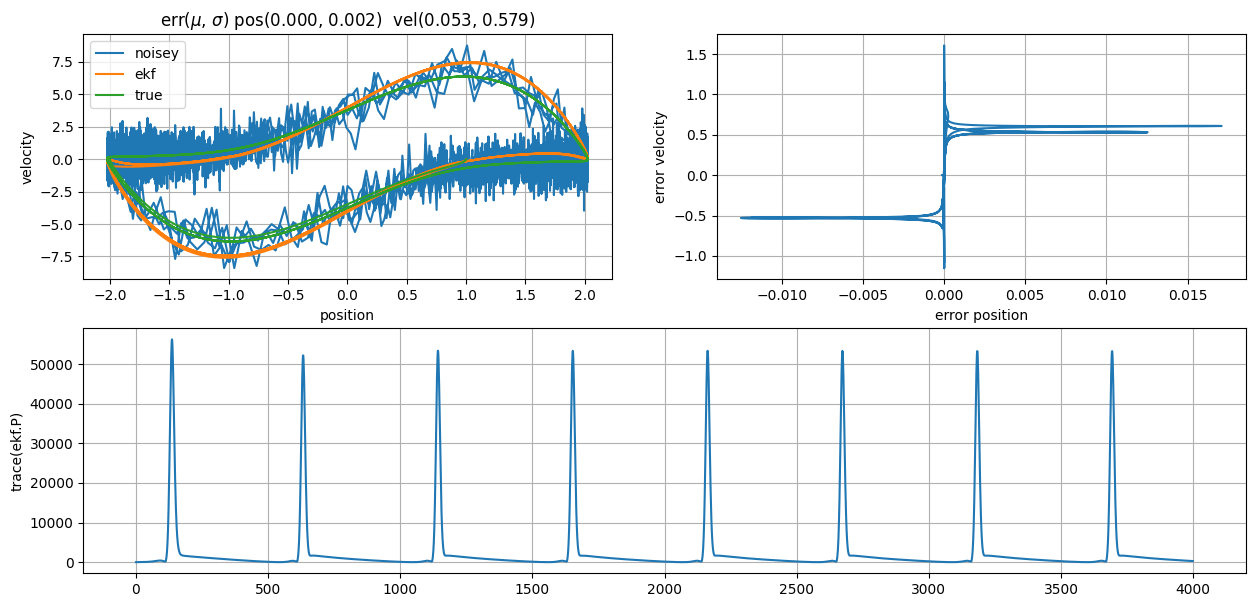

In [551]:
plt.figure(figsize=(15,7))
plt.subplot(221)
plt.plot(noisey[:,1],noisey[:,0],label="noisey")
plt.plot(ekf[:,1],ekf[:,0], label="ekf")
plt.plot(tru[:,1],tru[:,0], label="true")
plt.ylabel('velocity')
plt.xlabel('position')
plt.grid(True)
tru = data[2]
err = tru - ekf
mu = np.mean(err, axis=0)
std = np.std(err, axis=0)
plt.title(f"err($\mu$, $\sigma$) pos({mu[1]:.3f}, {std[1]:.3f})  vel({mu[0]:.3f}, {std[0]:.3f})")
plt.legend()

plt.subplot(222)
# tru = data[2]
# err = tru - ekf
plt.plot(err[:,1], err[:,0])
plt.ylabel('error velocity')
plt.xlabel('error position')
# # plt.title(f"max(|P|): {np.max(np.abs(err[:,1])):.3f}   max(|V|): {np.max(np.abs(err[:,0])):.3f}")
# # plt.title(f"$\sum |pos|$: {np.sum(np.abs(err[:,1])):.3f}       $\sum |vel|$: {np.sum(np.abs(err[:,0])):.3f}")
# mu = np.mean(err, axis=0)
# std = np.std(err, axis=0)
# plt.title(f"err($\mu$, $\sigma$) pos({mu[1]:.3f}, {std[1]:.3f})  vel({mu[0]:.3f}, {std[0]:.3f})")
plt.grid(True)
# plt.plot(tr)
# plt.title("trace(ekf.P)")
# plt.grid(True);

plt.subplot(212)
# plt.plot(err[:,1])
# plt.ylabel("err pos")
# plt.grid(True)
plt.plot(tr)
plt.ylabel("trace(ekf.P)")
plt.grid(True);

# plt.subplot(224)
# plt.plot(err[:,0])
# plt.ylabel("err vel")
# plt.grid(True);

The position error (x[1]) is small while the velocity error (x[0]) is very noticable. There is no direct measurement of velocity inside the filter, but there is direct measurement of the position.

## Automated Search

In [520]:
def plot2(f, i, r, a, b, title=None, left=None, right=None):
    # ax1 = plt.subplot()
    ax1 = f.add_subplot(2,2,i)
    l1 = ax1.plot(r,a, color="red")
    ax2 = ax1.twinx()
    l2 = ax2.plot(r,b, color="blue")
    if left is None:
        ax1.set_ylabel("mean(error)", color="r")
    else:
        ax1.set_ylabel(left, color="r")
    if right is None:
        ax2.set_ylabel("std(error)", color="b")
    else:
        ax2.set_ylabel(right, color="b")
    # plt.legend(True)
    ax1.set_title(title)
    plt.grid(True)
    return f

def plot(f, i, r, a, title=None, left=None):
    ax1 = f.add_subplot(2,2,i)
    l1 = ax1.plot(r,a, color="red")
    if left is None:
        ax1.set_ylabel("mean(error)", color="r")
    else:
        ax1.set_ylabel(left, color="r")
    # plt.legend(True)
    ax1.set_title(title)
    plt.grid(True)
    return f
    

In [525]:
def filterSearch(states,dt, func, tru, r):
    yi = []
    tr = []
    # create a kalman filter
    ekf = EKF(func, dt, 2, 2)

    # so reset puts R and Q to identify matrix, you should
    # adjust them to your system
    ekf.reset()
    ekf.P *= 0.5
    ekf.R *= [r,10*r]
    # ekf.R *= r #[.05,.01] # measurement cov
    # ekf.R *= [2,.01] # rms sensor noise squared
    # ekf.Q *= [0.025,0.00] # process cov
    ekf.Q *= 0.1
    # print("Q",ekf.Q)
    ekf.H = np.array([[0,0],[0,1]]) # only measure position, not vel
    ekf.x = np.array([0,1]) # default sets this to zeros
    
    for (v,p) in states:
        ekf.predict(0)
        # meas = np.array([ekf.x[0],p])
        meas = np.array([0,p])
        y = ekf.update(meas)
        yi.append(y)
        tr.append(np.trace(ekf.P))

    yi = np.array(yi)
    tr = np.array(tr)
    
    err = tru - yi
    mu = np.mean(err,axis=0)
    std = np.std(err,axis=0)
    aerr = np.sum(np.abs(err),axis=0)
    
    maxP = np.log(np.max(tr))
    meanP = np.log(np.mean(tr))
    # print(ekf.P)
    
    return mu, std, maxP, meanP, aerr

pts = []
vp2 = Vanderpol(5.) # didn't model system right
for r in tqdm(np.arange(0.1, 1.5, 0.1)):
    mu,std,maxP,meanP,aerr = filterSearch(noisey,step,vp2.eqns, tru, r)
    pts.append(np.hstack((r, mu,std,maxP,meanP,aerr)))
    
pts = np.array(pts)

100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]


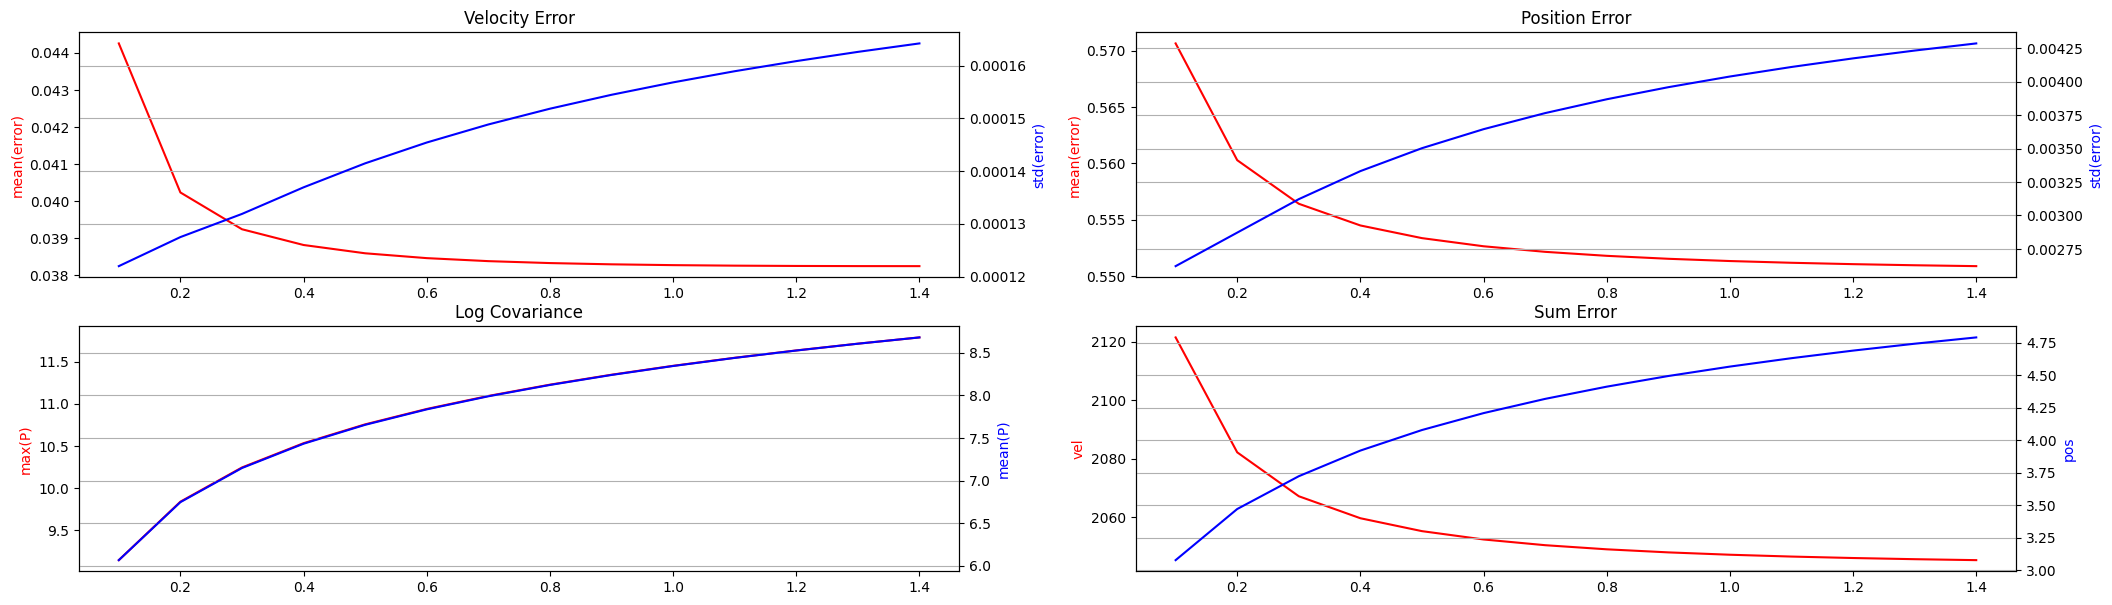

In [530]:
f = plt.figure(figsize=(25,7))
f = plot2(f,1,pts[:,0],pts[:,1],pts[:,2], "Velocity Error")
f = plot2(f,2,pts[:,0],pts[:,3],pts[:,4], "Position Error")
f = plot2(f,3,pts[:,0],pts[:,5],pts[:,6], "Log Covariance",left="max(P)",right="mean(P)")
f = plot2(f,4,pts[:,0],pts[:,7],pts[:,8], "Sum Error",left="vel", right="pos")

In [524]:
e=tru - ekf
np.sum(e,axis=0)

array([236.26896345,   0.3278943 ])

In [527]:
pts.shape

(14, 9)

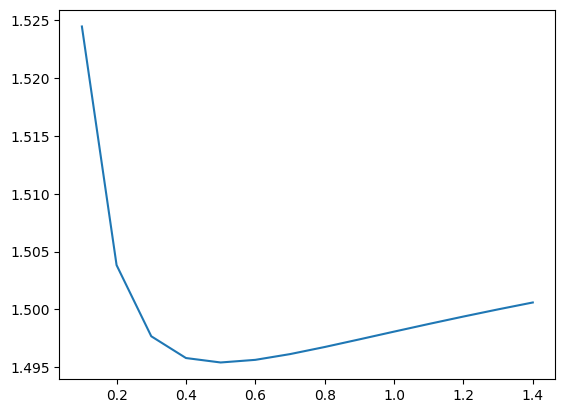

In [549]:
v,p = np.sum(pts[:,7:],axis=0)
plt.plot(pts[:,0], 20*pts[:,7]/v+pts[:,8]/p)

In [540]:
pts[:,7]/np.sum(pts[:,7])

array([0.07362135, 0.07225735, 0.07173628, 0.07147518, 0.07132208,
       0.0712233 , 0.07115534, 0.07110642, 0.07106998, 0.07104212,
       0.07102038, 0.07100311, 0.07098921, 0.07097791])

In [544]:
p

59.12700189823748

In [545]:
v

28816.563526979975